# SEJM VII RP

Now we will analyze text data of parliamentary speeches from Polish Sejm from the previous cadency. 

The data was downloaded using [this API](https://mojepanstwo.pl/api/sejmometr). 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sejm = pd.read_csv('../data/sejm.csv')

In [6]:
sejm.shape

(71259, 4)

In [4]:
sejm.columns

Index(['lemma', 'text', 'name', 'date'], dtype='object')

In [7]:
sejm.groupby('name')['text'].\
    apply(lambda x: len(x)).\
    sort_values().nlargest(10)

name
Ewa Kopacz                     8057
Wanda Nowicka                  6558
Eugeniusz Tomasz Grzeszczak    6175
Jerzy Wenderlich               6030
Cezary Grabarczyk              5928
Marek Kuchciński               5738
Romuald Ajchler                 573
Radosław Sikorski               547
Piotr Szeliga                   485
Ryszard Zbrzyzny                415
Name: text, dtype: int64

In [8]:
sejm.groupby('name')['text'].\
    apply(lambda x: len(x)).\
    sort_values().nsmallest(10)

name
Piotr Król                     1
Krzysztof Sońta                1
Andrzej Smirnow                1
Teresa Świło                   1
Ewa Czeszejko-Sochacka         1
Łukasz Tusk                    1
Elżbieta Królikowska-Kińska    1
Aleksander Sosna               1
Robert Jagła                   1
Aldona Młyńczak                1
Name: text, dtype: int64

In [7]:
filtered = sejm.groupby('name')['text'].\
    filter(lambda x: len(x) >= 10)
sejm = sejm[sejm['text'].isin(filtered)]

In [8]:
sejm.groupby('name')['text'].\
    apply(lambda x : np.mean(x.str.len())).\
    sort_values(ascending=False).nlargest(10)

name
Wojciech Rafał Wiewiórowski    20848.833333
Marek Michalak                 15007.142857
Donald Tusk                    14992.770833
Olgierd Dziekoński             12197.333333
Sławomir Nowak                  9996.300000
Władysław Kosiniak-Kamysz       9174.230769
Piotr Serafin                   8612.800000
Tomasz Siemoniak                8471.545455
Jarosław Gowin                  7785.571429
Jarosław Kaczyński              7489.142857
Name: text, dtype: float64

In [11]:
sejm['text'][0]

' Przystępujemy do rozpatrzenia punktu 16.  porządku dziennego: Zmiany w składach osobowych komisji sejmowych .  Prezydium Sejmu na podstawie art.  20 ust.  1 i art.  148a ust.  12 regulaminu Sejmu, po zasięgnięciu opinii Konwentu Seniorów, przedłożyło wniosek w sprawie zmian w składach osobowych komisji sejmowych.  Czy ktoś z pań i panów posłów pragnie zabrać głos w sprawie przedstawionych propozycji?  Nie widzę.  Nikt się nie zgłasza.  Przystępujemy zatem do głosowania. '

## What did PIS and PO talk about?

In [38]:
sejm_dict = pd.read_csv('../data/sejm7.csv', delimiter=';', header=None, usecols=[0, 3])
sejm_dict.columns = ['name', 'party']

In [108]:
sejm_dict = sejm_dict.drop_duplicates(subset='name')
# we ignore the fact that party can be changed throughout a cadency
sejm_dict.head()

,name,party
0,Adam Abramowicz,PiS
1,Małgorzata Adamczak,PO
2,Andrzej Adamczyk,PiS
3,Romuald Ajchler,SLD
4,Leszek Aleksandrzak,SLD


In [112]:
sejm = sejm.merge(sejm_dict, how='left')
sejm['party'].value_counts()

PO     22461
PiS    15305
Name: party, dtype: int64

In [113]:
filtered_rows = (sejm['party'].isin(['PO', 'PiS'])) & (sejm['party'].notnull())
sejm = sejm[filtered_rows]
sejm = sejm.reset_index()

## Lemmas

We have already prepared lemmatized version of speeches (for lemmatization we used [KNNRT](../notebooks/0_krnnt_examples.ipynb), but you can also try [Morfeusz](../notebooks/0_morfeusz_examples.ipynb)).

In [114]:
np.array(sejm['lemma'])[:2]

array(['przystępować do rozpatrzyć punkt 16 . porządek dzienny : zmiana w skład osobowy komisja sejmowy . prezydium sejm na podstawa artykuł . 20 ustęp . 1 i artykuł . 148a ustęp . 12 regulamin sejm , po zasięgnąć opinia konwent senior , przedłożyć wniosek w sprawa zmiana w skład osobowy komisja sejmowy . czy ktoś z pani i pan poseł pragnąć zabrać głos w sprawa przedstawić propozycja ? nie widzieć . nikt się nie zgłaszać . przystępować zatem do głosować .',
       'kto z pani i pan poseł być za przyjąć wniosek prezydium sejm w sprawa wybór skład osobowy komisja do sprawa służba specjalny , w brzmienie proponować w druk numer 15 , zechcieć podnieść ręka i nacisnąć przycisk . kto być przeciw ? kto się wstrzymać ? głosować 435 poseł . za oddać swój głos 381 poseł , przeciw – 53 poseł , 1 poseł wstrzymać się od głos . stwierdzać , że sejm dokonać wybór skład osobowy komisja do sprawa służba specjalny . na to wyczerpać być porządek dzienny 1 . posiedzenie sejm Rzeczpospolita polski .'],
   

## Initial cleaning

We will replace all numerics with a `NUM` string.

In [115]:
sejm['lemma'] = np.array(sejm['lemma'].replace(' \d+ ', ' NUM ', regex=True))

In [116]:
sejm['lemma'][0]

'przystępować do rozpatrzyć punkt NUM . porządek dzienny : zmiana w skład osobowy komisja sejmowy . prezydium sejm na podstawa artykuł . NUM ustęp . NUM i artykuł . 148a ustęp . NUM regulamin sejm , po zasięgnąć opinia konwent senior , przedłożyć wniosek w sprawa zmiana w skład osobowy komisja sejmowy . czy ktoś z pani i pan poseł pragnąć zabrać głos w sprawa przedstawić propozycja ? nie widzieć . nikt się nie zgłaszać . przystępować zatem do głosować .'

### Quick look at stopwords

Term *stopwords* usually refers to the most common words in a language, however, there is no single universal list of stop words. In our example we may consider adding different words to the stopwords list, e.g. *marszałek* (all speeches are addressed *marszałek*), or removing words, e.g. *po* (as it has different meaning).

They usually bring little meaning.

In [32]:
with open('../data/polish.stopwords.txt', 'r') as f:
    stopwords = f.readlines()
stopwords = [x.strip('\n') for x in stopwords]
stopwords[:10]

['a', 'aby', 'ach', 'acz', 'aczkolwiek', 'aj', 'albo', 'ale', 'alez', 'ależ']

In [33]:
np.any([x == 'po' for x in stopwords])

True

In [34]:
stopwords.remove('po')

`sklearn`'s `CountVectorizer` automatically removes stopwords.

## LDA in sklearn

In [43]:
from sklearn.feature_extraction.text import CountVectorizer

In [44]:
cv = CountVectorizer(min_df=0.01, 
                     max_df=0.3, 
                     stop_words=stopwords)

In [45]:
cv_X = cv.fit_transform(sejm['lemma'])
cv_X

<37766x1363 sparse matrix of type '<class 'numpy.int64'>'
	with 1731866 stored elements in Compressed Sparse Row format>

In [46]:
counts = pd.DataFrame({
    'word': cv.get_feature_names(),
    'count': cv_X.toarray().sum(axis=0)
})

In [47]:
counts.sort_values('count', ascending=False).head(15)

,count,word
843,45719,rok
729,29417,projekt
568,25896,państwo
316,24278,komisja
714,21782,prawo
922,21734,sprawa
634,21377,polski
647,20788,poprawka
414,20354,móc
592,20182,po


In [74]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

n_components = 10
lda = LDA(n_components=n_components, 
          max_iter=5,
          learning_method='online',
          random_state=123)
lda.fit(cv_X)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_components=10, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=123, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [75]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = 'Topic #%d: ' % topic_idx
        message += ' '.join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [76]:
print_top_words(lda, cv.get_feature_names(), 12)

Topic #0: podatek spółka umowa polska państwo przedsiębiorca podatkowy rynek polski działalność koszt skarb
Topic #1: polski rok polska po zostać swój służba narodowy rzeczpospolita dzień sprawa rada
Topic #2: komisja projekt sejm sprawozdanie wniosek punkt dyskusja zmiana porządek sprawa dzienny uchwała
Topic #3: projekt prawo zmiana przepis artykuł dotyczyć klub praca sprawa sąd sprawiedliwość osoba
Topic #4: pytanie prawo godzina sprawiedliwość obywatelski platforma zabrać zadać wicemarszałek klub odpowiedź sprawa
Topic #5: dziecko szkoła zdrowie rodzina rok osoba system rodzic móc program problem pacjent
Topic #6: rok program droga środek europejski samorząd zostać realizacja rozwój inwestycja dotyczyć zadanie
Topic #7: rok praca złoty budżet osoba miliard społeczny milion fundusz publiczny wzrost kwota
Topic #8: poprawka wstrzymać przyjąć głosować senat odrzucić przeciw głosowanie ręka podnieść zechcieć stwierdzać
Topic #9: chcieć państwo mówić móc powiedzieć po pytanie chodzić rz

You may consider using different stopwords, e.g. are *rok*, *punkt* necessary?

### Visualize documents

Can LDA help us to characterize political language in Polish parliament? Let's start by plotting topic distribution for different parties.

In [77]:
lda_features = lda.transform(cv_X)
party_lda = pd.concat([pd.DataFrame(lda_features), 
                     sejm['party'].reset_index()['party']], axis=1)

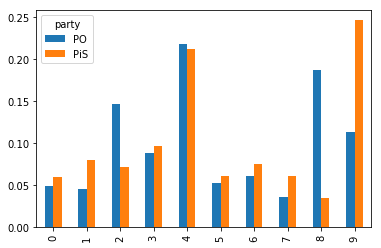

In [78]:
bar_pca = party_lda.\
    groupby('party').mean().transpose().plot.bar()

**Task**

Visualize LDA in 2d space grouped by party. Try PCA or t-SNE (t-SNE may take much time to converge).

**Task**

Pick one topic and visualize its share changes in time.

**Task** (Exhaustive)

Play with different numbers of topics in LDA. Try grid searching over number of topics maximizing log-likelihood. Which number is the best for the party classification problem?

**Task**

Compare different parties subsets using LDA.